# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S11

## Panel a

In [2]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig7'+'/FYN_coreDTS_bPCA_order1/task_1/predictions/predicted_phenotypes_all.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

predicted_abundance = predicted_phenotypes.loc[predicted_phenotypes['Abundance']==1]
predicted_binding = predicted_phenotypes.loc[predicted_phenotypes['Binding']==1]

In [3]:
# Normalize data

from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

RT=303*0.001987

predicted_abundance_scaled = predicted_abundance.copy()
predicted_binding_scaled = predicted_binding.copy()

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

# Normalize abundance fitness measurements

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_abundance, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])


predicted_abundance_scaled['fitness']=        normalize(list(predicted_abundance_scaled['fitness']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_abundance_scaled['fitness1_uncorr']=normalize(list(predicted_abundance_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_abundance_scaled['fitness2_uncorr']=normalize(list(predicted_abundance_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Normalize abundance fitness predictions

for index, row in predicted_abundance_scaled.loc[predicted_abundance_scaled['WT']!=True].iterrows():
    predicted_abundance_scaled.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_abundance_scaled.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_abundance_scaled, x='predicted_fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

predicted_abundance_scaled['predicted_fitness']=           normalize(list(predicted_abundance_scaled['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Obtain mean inferred folding ddGs

predicted_abundance_scaled['mean_additive_trait']=predicted_abundance_scaled[['fold_'+str(i)+'_additive_trait0' for i in range(1,11,1)]].mean(axis=1)
predicted_abundance_scaled['std_additive_trait']=predicted_abundance_scaled[['fold_'+str(i)+'_additive_trait0' for i in range(1,11,1)]].std(axis=1)

predicted_abundance_scaled['mean_ddG']= predicted_abundance_scaled['mean_additive_trait']*RT
predicted_abundance_scaled['std_ddG']=  predicted_abundance_scaled['std_additive_trait']*RT

# Normalize binding fitness measurements

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_binding, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])


predicted_binding_scaled['fitness']=        normalize(list(predicted_binding_scaled['fitness']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness1_uncorr']=normalize(list(predicted_binding_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness2_uncorr']=normalize(list(predicted_binding_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness3_uncorr']=normalize(list(predicted_binding_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Normalize binding fitness predictions

for index, row in predicted_binding_scaled.loc[predicted_binding_scaled['WT']!=True].iterrows():
    predicted_binding_scaled.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_binding_scaled.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_binding_scaled, x='predicted_fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

predicted_binding_scaled['predicted_fitness']=           normalize(list(predicted_binding_scaled['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Obtain mean inferred binding ddGs

predicted_binding_scaled['mean_additive_trait']=predicted_binding_scaled[['fold_'+str(i)+'_additive_trait1' for i in range(1,11,1)]].mean(axis=1)
predicted_binding_scaled['std_additive_trait']=predicted_binding_scaled[['fold_'+str(i)+'_additive_trait1' for i in range(1,11,1)]].std(axis=1)

predicted_binding_scaled['mean_ddG']= predicted_binding_scaled['mean_additive_trait']*RT
predicted_binding_scaled['std_ddG']=  predicted_binding_scaled['std_additive_trait']*RT

In [4]:
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'predicted_fitness': 'predicted_stability_fitness'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'predicted_fitness': 'predicted_binding_fitness'})
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'fitness': 'stability_fitness'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'fitness': 'binding_fitness'})
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'mean_ddG': 'folding_ddG'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'mean_ddG': 'binding_ddG'})
predicted_stability_vs_binding = predicted_binding_scaled.merge(predicted_abundance_scaled, left_on='aa_seq', right_on='aa_seq')

In [5]:
import matplotlib
#matplotlib.use('QT4Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

class MyAxes3D(axes3d.Axes3D):

    def __init__(self, baseObject, sides_to_draw):
        self.__class__ = type(baseObject.__class__.__name__,
                              (self.__class__, baseObject.__class__),
                              {})
        self.__dict__ = baseObject.__dict__
        self.sides_to_draw = list(sides_to_draw)
        self.mouse_init()

    def set_some_features_visibility(self, visible):
        for t in self.zaxis.get_ticklines() + self.zaxis.get_ticklabels():
            t.set_visible(visible)
        self.zaxis.line.set_visible(visible)
        self.zaxis.pane.set_visible(visible)
        self.zaxis.label.set_visible(visible)
        

    def draw(self, renderer):
        # set visibility of some features False 
        self.set_some_features_visibility(True)
        # draw the axes
        super(MyAxes3D, self).draw(renderer)
        # set visibility of some features True. 
        # This could be adapted to set your features to desired visibility, 
        # e.g. storing the previous values and restoring the values
        self.set_some_features_visibility(True)

        zaxis = self.zaxis
        draw_grid_old = zaxis.axes._draw_grid
        # disable draw grid
        #zaxis.axes._draw_grid = False

        tmp_planes = zaxis._PLANES

        if 'l' in self.sides_to_draw :
            # draw zaxis on the left side
            zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                             tmp_planes[0], tmp_planes[1],
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)
        if 'r' in self.sides_to_draw :
            # draw zaxis on the right side
            zaxis._PLANES = (tmp_planes[3], tmp_planes[2], 
                             tmp_planes[1], tmp_planes[0], 
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)

        zaxis._PLANES = tmp_planes

        # disable draw grid
        #zaxis.axes._draw_grid = draw_grid_old

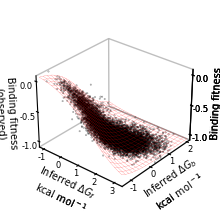

In [6]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the modified sigmoid function in 3D with upper and lower plateaus
def sigmoid_3d(xy, a, b, c, lower_plateau, upper_plateau):
    x, y = xy
    return lower_plateau + (upper_plateau - lower_plateau) / (1 + np.exp(-(a*x + b*y + c)))

# Define data
x_data = predicted_stability_vs_binding['folding_ddG'].to_numpy()
y_data = predicted_stability_vs_binding['binding_ddG'].to_numpy()
z_data = predicted_stability_vs_binding['binding_fitness'].to_numpy()

# Initial guess for parameters
lower_plateau=min(z_data)
upper_plateau=max(z_data)
initial_guess = (1, 1, 1, lower_plateau, upper_plateau)

# Fit the modified 3D sigmoid surface to the data
params, covariance = curve_fit(sigmoid_3d, (x_data, y_data), z_data, p0=initial_guess)

# Extract the fitted parameters
a, b, c, lower_plateau_fit, upper_plateau_fit = params

# Create a meshgrid within the range [-2, 2] for plotting the surface
x_mesh, y_mesh = np.meshgrid(np.linspace(min(x_data), max(x_data), 100), np.linspace(min(y_data), max(y_data), 100))
z_fit = sigmoid_3d((x_mesh, y_mesh), a, b, c, lower_plateau_fit, upper_plateau_fit)

# Calculate the minimum and maximum values of the fitted surface
z_min, z_max = np.min(z_fit), np.max(z_fit)
x_min, x_max = np.min(x_mesh), np.max(x_mesh)
y_min, y_max = np.min(y_mesh), np.max(y_mesh)

# Plot the original data points and the fitted wireframe surface
fig = plt.figure(figsize=(2.2,2.2))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, color='black', label='Original Data', alpha=0.5, s=0.1, rasterized=True)
surf = ax.plot_wireframe(x_mesh, y_mesh, z_fit, color='red', label='Fitted Surface', rstride=5, cstride=5, linewidth=0.1)

# Set xlim, ylim, and zlim to touch the axes
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

ax.set_xlabel(r'Inferred ${ΔG_{f}}$'+ '\n'+ r'kcal mol$^-$$^1$', fontsize=7, labelpad=-8)
ax.set_ylabel(r'Inferred ${ΔG_{b}}$'+ '\n'+ r'kcal mol$^-$$^1$', fontsize=7, labelpad=-8)
ax.set_zlabel('Binding fitness\n(observed)', fontsize=7, labelpad=-8)
ax.tick_params(axis="y", pad=-6)
ax.tick_params(axis="z", pad=-4)
ax.tick_params(axis="x", pad=-6)
ax.set_xticks(np.arange(-1,4,1),labels=np.arange(-1,4,1),fontsize=6)
ax.set_yticks(np.arange(-1,3,1),labels=np.arange(-1,3,1),fontsize=6)
ax.set_zticks(np.arange(-1,0.5,0.5),labels=np.arange(-1,0.5,0.5),fontsize=6)

ax.set_rasterization_zorder(0)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('gray')
ax.yaxis.pane.set_edgecolor('gray')
ax.zaxis.pane.set_edgecolor('gray')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax = fig.add_axes(MyAxes3D(ax, 'lr'))
ax.view_init(elev=30, azim=310)

# Unpack the meshgrid values before passing to legend
#ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5),
#                   plt.Line2D([0], [0], color='blue', linewidth=1, label='Fitted Surface')],
#          labels=['Original Data', 'Fitted Surface'])

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_1storder3statemodel_folding_n_bidning_phenotypevsaddG.svg', dpi=300, transparent=True)#, bbox_inches='tight')

## Panel b

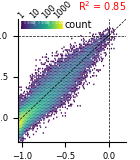

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

overall_full_model_performance = pd.DataFrame()

y = predicted_binding_scaled.loc[predicted_binding_scaled['WT']!=True].loc[predicted_binding_scaled['predicted_binding_fitness'].notnull()][['binding_fitness']].to_numpy()
x = predicted_binding_scaled.loc[predicted_binding_scaled['WT']!=True].loc[predicted_binding_scaled['predicted_binding_fitness'].notnull()][['predicted_binding_fitness']].to_numpy()
model = LinearRegression()
model.fit(x,y)
y_pred = model.predict(x)

fig, ax = plt.subplots(figsize=(1.4,1.6))
hbin=ax.hexbin(x=predicted_binding_scaled['predicted_binding_fitness'].loc[predicted_binding_scaled['WT']!=True],y=predicted_binding_scaled['binding_fitness'].loc[predicted_binding_scaled['WT']!=True],bins='log',gridsize=75,rasterized=True,linewidths=0,vmax=1000)
ax.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)


plt.axvline(0, ls='--', color='black', lw=0.5)
plt.axhline(0, ls='--', color='black', lw=0.5)
plt.title('\nR$^2$ = '+str(round(r2_score(y,y_pred),2)),fontsize=7, color='r', loc='right')
overall_full_model_performance.at['1','All']=round(r2_score(y,y_pred),2)
plt.xlabel('binding fitness\n(predicted)', fontsize=7)
plt.xticks(fontsize=6)
plt.ylabel('binding fitness\n(observed)', fontsize=7)
plt.yticks(fontsize=6)
ax.set_xticks(np.arange(-1.5,0.5,0.5))
ax.set_yticks(np.arange(-1.5,0.5,0.5))
ax.set_ylim(-1.3,0.2)
ax.set_xlim(-1.05,0.2)
ax.spines[['top','right']].set_visible(False)
ax.set_rasterization_zorder(0)
fmt = '%1.f'
cax=fig.add_axes([0.15,0.82,0.3,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
#cb.ax.set_title('Count', fontsize=7)
#cb.set_label('count', rotation=0, fontsize=7, labelpad=2)
#cb.ax.xaxis.set_label_position('right')
cb.set_ticks([1,10,100,1000])
cb.set_ticklabels([1,10,100,1000], fontsize=6, rotation=45)
ax1 = cb.ax
ax1.text(1200,0.1,'count',rotation=0, fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_1storder3statemodel_binding_performance.svg', dpi=300, transparent=True, bbox_inches='tight')


## Panel c

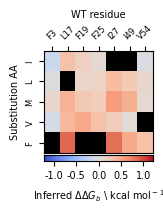

In [8]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

coefs = pd.read_csv(path+'Fig7/'+'FYN_coreDTS_bPCA_order1/task_1/weights/weights_Binding.txt',
                       sep='\t')
coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    if row['id'] != 'WT':
        coefs.at[index,'order']=len(row.id.split('_'))
    else:
        coefs.at[index,'order']=0
coefs_1stor=coefs.copy()


firstorderterms=coefs.loc[coefs['order']==1].copy()

for index, row in firstorderterms.iterrows():
    firstorderterms.at[index,'mut_from']=row.id[0:-1]
    firstorderterms.at[index,'wt_res']=row.id[0]
    firstorderterms.at[index,'mut_pos']=row.id[1:-1]
    firstorderterms.at[index,'mut_to']=row.id[-1]

real_pos = [2,16,18,24,26,48,53]
mutated_positions = []

for index, row in firstorderterms.iterrows():
    if row.id !='WT' and row.mut_from not in mutated_positions:
        mutated_positions.append(row.mut_from)

coefs_hm=pd.DataFrame(columns=mutated_positions)

for index, row in firstorderterms.iterrows():
    if row.id !='WT':
        coefs_hm.at[row.mut_to,row.mut_from]=row.mean_kcal_mol

fig, ax = plt.subplots(figsize=(1.4,1.6))

singles_boundary=max(abs(coefs['mean_kcal_mol']))

ax=sns.heatmap(coefs_hm.fillna(0), cmap='coolwarm', vmin=-1*singles_boundary, vmax=singles_boundary,cbar_kws={"orientation": "horizontal", "pad": 0.02, 'location':'bottom'}, xticklabels=True, yticklabels=True)

ax.figure.axes[-1].set_xticks(ticks=np.arange(-1,1.5,0.5),labels=np.arange(-1,1.5,0.5),fontsize=7)
ax.figure.axes[-1].set_xlabel(r'Inferred ${ΔΔG_{b}}$ \ kcal mol$^-$$^1$', rotation=0, labelpad=5, fontsize=7)
ax.spines[['right','left','top','bottom']].set_visible(True)
ax.figure.axes[-1].spines[['right','left','top','bottom']].set_visible(True)
plt.tick_params(axis='both', which='both', labelsize=7, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(fontsize=6)
plt.xticks(fontsize=6, rotation=45)
plt.xlabel('WT residue',  fontsize=7)
ax.xaxis.set_label_position('top') 
plt.ylabel('Substitution AA', fontsize=7)

for i in mutated_positions:
    for j in mutated_positions:
        if i[0]==j[0]:
            col=coefs_hm.columns.get_loc(i)
            row=coefs_hm.index.get_loc(j[0])
            ax.add_patch(Rectangle((col, row), 1, 1, fill=True,edgecolor='black', lw=0.0001, facecolor='black'))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_binding_1storderterms_1storder3statemodel_ddGs.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel d

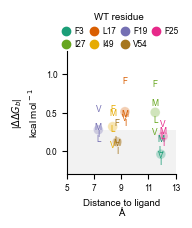

In [9]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

from pylab import *
import matplotlib as mpl
import itertools
mpl.rc('font',family='Arial')

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

dist_core_lig = [11.916178703308105, 9.267768859863281, 7.30642032623291, 12.082030296325684, 11.4977388381958, 8.362347602844238, 8.694024085998535] # minimum side chain heavy atom distances to ligand 
#dist_core_lig = [11.916177749633789, 7.154636859893799, 7.30642032623291, 12.082030296325684, 11.4977388381958, 5.728403568267822, 7.581732749938965] # minimum all atom distances to ligand
# legend label ordered by distance
pos_df = pd.DataFrame({'dist':dist_core_lig}, index=coefs_hm.columns)
pos_dist_asc = pos_df.sort_values(by='dist').index.to_list()

y = coefs_hm.T.to_numpy().flatten()
listoflists = [np.repeat(dist_core_lig[i], 5) for i in range(0,7)]
x = [item for list in listoflists for item in list]

fig, ax = plt.subplots(figsize=(1.4,1.6))
ax.axhspan(-1, coefs_hm.mean().mean(), facecolor='gray', alpha=0.1)
sns.scatterplot(x=x,y=y, hue=np.repeat(coefs_hm.columns, 5), s=0, palette='Dark2')
sns.scatterplot(x=dist_core_lig,y=coefs_hm.mean(), palette='Dark2',s=50,marker='o', alpha=0.3, hue=list(pos_df.index))
#plt.axhline(coefs_hm.mean().mean(), linestyle='--', color='red', linewidth=1)
#plt.axvline(5, linestyle='--', color='black', linewidth=1)
h, l = ax.get_legend_handles_labels()
plt.legend(flip(h[0:7],4),flip(l[0:7],4),title = 'WT residue', fontsize=6, title_fontsize=7, frameon=False, ncol=(len(pos_df.index)+1)/2,bbox_to_anchor=(1.1,1.37), columnspacing=0, handletextpad=0)
plt.xlabel('Distance to ligand\nÅ', fontsize=7)
plt.ylabel(r'|${ΔΔG_{b}}$|'+ '\n'+ r'kcal mol$^-$$^1$', fontsize=7)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax.set_xticks(np.arange(5,15,2))
#ax.set_yticks(np.arange(-1.5,0.5,0.5))
ax.set_ylim(-0.3,1.3)
ax.spines[['top','right']].set_visible(False)
#ax.get_legend().remove()

# TODO jitter label
def label_point(x, y, val, ax, colors):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    col = a.iloc[0]['x']
    counter=0
    for i, point in a.iterrows():
        if point['x'] != col:
            col=point['x']
            counter+=1
        ax.text(point['x'], point['y'], str(point['val']), fontsize=6, color=colors[counter], ha='center')

colors=list(sns.color_palette('Dark2',len(pos_df)))


label_point(pd.Series(x).loc[pd.Series(y).notnull()], pd.Series(y).loc[pd.Series(y).notnull()], pd.Series(np.tile(coefs_hm.index, 7)).loc[pd.Series(y).notnull()], plt.gca(), colors)

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_binding_ddGs_1storder3statemodel_vs_distance_scatter.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel e

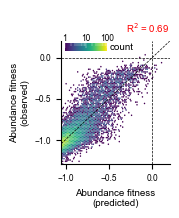

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

overall_full_model_performance_stability = pd.DataFrame()

y = predicted_abundance_scaled.loc[predicted_abundance_scaled['WT']!=True][['stability_fitness']].to_numpy()
x = predicted_abundance_scaled.loc[predicted_abundance_scaled['WT']!=True][['predicted_stability_fitness']].to_numpy()
model = LinearRegression()
model.fit(x,y)
y_pred = model.predict(x)

fig, ax = plt.subplots(figsize=(1.4,1.6))
hbin=ax.hexbin(x=predicted_abundance_scaled['predicted_stability_fitness'].loc[predicted_abundance_scaled['WT']!=True],y=predicted_abundance_scaled['stability_fitness'].loc[predicted_abundance_scaled['WT']!=True],bins='log',gridsize=75,rasterized=True,linewidths=0,vmax=100)
ax.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)


plt.axvline(0, ls='--', color='black', lw=0.5)
plt.axhline(0, ls='--', color='black', lw=0.5)
plt.title('\nR$^2$ = '+str(round(r2_score(y,y_pred),2)),fontsize=7, color='r', loc='right')
overall_full_model_performance_stability.at['1','All']=round(r2_score(y,y_pred),2)
plt.xlabel('Abundance fitness\n(predicted)', fontsize=7)
plt.xticks(fontsize=6)
plt.ylabel('Abundance fitness\n(observed)', fontsize=7)
plt.yticks(fontsize=6)
ax.set_xticks(np.arange(-1.5,0.5,0.5))
ax.set_yticks(np.arange(-1.5,0.5,0.5))
ax.set_ylim(-1.3,0.2)
ax.set_xlim(-1.05,0.2)
ax.spines[['top','right']].set_visible(False)
ax.set_rasterization_zorder(0)
fmt = '%1.f'
cax=fig.add_axes([0.15,0.82,0.3,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
#cb.ax.set_title('Count', fontsize=7)
#cb.set_label('count', rotation=0, fontsize=7, labelpad=2)
#cb.ax.xaxis.set_label_position('right')
cb.set_ticks([1,10,100])
cb.set_ticklabels([1,10,100], fontsize=6)
ax1 = cb.ax
ax1.text(140,0.1,'count',rotation=0, fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_1storder_abundance_performance_bindingPCA.svg', dpi=300, transparent=True, bbox_inches='tight')


## Panel f

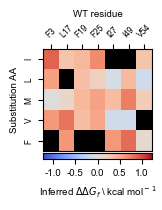

In [11]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

coefs = pd.read_csv(path+'Fig7/'+'FYN_coreDTS_bPCA_order1/task_1/weights/weights_Folding.txt',
                       sep='\t')
coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    if row['id'] != 'WT':
        coefs.at[index,'order']=len(row.id.split('_'))
    else:
        coefs.at[index,'order']=0
coefs_1stor=coefs.copy()


firstorderterms=coefs.loc[coefs['order']==1].copy()

for index, row in firstorderterms.iterrows():
    firstorderterms.at[index,'mut_from']=row.id[0:-1]
    firstorderterms.at[index,'wt_res']=row.id[0]
    firstorderterms.at[index,'mut_pos']=row.id[1:-1]
    firstorderterms.at[index,'mut_to']=row.id[-1]

real_pos = [2,16,18,24,26,48,53]
mutated_positions = []

for index, row in firstorderterms.iterrows():
    if row.id !='WT' and row.mut_from not in mutated_positions:
        mutated_positions.append(row.mut_from)

coefs_hm=pd.DataFrame(columns=mutated_positions)

for index, row in firstorderterms.iterrows():
    if row.id !='WT':
        coefs_hm.at[row.mut_to,row.mut_from]=row.mean_kcal_mol

fig, ax = plt.subplots(figsize=(1.4,1.6))

ax=sns.heatmap(coefs_hm.fillna(0), cmap='coolwarm', vmin=-1*singles_boundary, vmax=singles_boundary,cbar_kws={"orientation": "horizontal", "pad": 0.02, 'location':'bottom'}, xticklabels=True, yticklabels=True)

ax.figure.axes[-1].set_xticks(ticks=np.arange(-1,1.5,0.5),labels=np.arange(-1,1.5,0.5),fontsize=7)
ax.figure.axes[-1].set_xlabel(r'Inferred ${ΔΔG_{f}}$ \ kcal mol$^-$$^1$', rotation=0, labelpad=5, fontsize=7)
ax.spines[['right','left','top','bottom']].set_visible(True)
ax.figure.axes[-1].spines[['right','left','top','bottom']].set_visible(True)
plt.tick_params(axis='both', which='both', labelsize=7, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(fontsize=6)
plt.xticks(fontsize=6, rotation=45)
plt.xlabel('WT residue',  fontsize=7)
ax.xaxis.set_label_position('top') 
plt.ylabel('Substitution AA', fontsize=7)
#plt.title('Background-averaged\nmutational effects',fontsize=18)

for i in mutated_positions:
    for j in mutated_positions:
        if i[0]==j[0]:
            col=coefs_hm.columns.get_loc(i)
            row=coefs_hm.index.get_loc(j[0])
            ax.add_patch(Rectangle((col, row), 1, 1, fill=True,edgecolor='black', lw=0.0001, facecolor='black'))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_folding_1storderterms_1storder3statemodel_ddGs.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel g

In [12]:
stability_weights_3state = coefs.copy()

stability_weights_2state=pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order1/task_1/weights/weights_Folding.txt',
                   sep='\t')

for index, row in stability_weights_2state.iterrows():
    if row.id != 'WT':
        stability_weights_2state.at[index,'order']=len(row.id_ref.split('_'))
    else:
        stability_weights_2state.at[index,'order']=0

stability_weights_2state.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol'}, inplace=True)

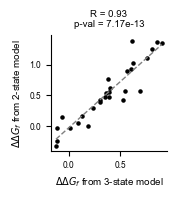

In [13]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

stability_weights_3state = stability_weights_3state.rename(columns={'mean_kcal_mol':'mean_kcal_mol_3state'})
stability_weights_2state = stability_weights_2state.rename(columns={'mean_kcal_mol':'mean_kcal_mol_2state'})

singles_folding_ddGs_2statevs3statemodels = stability_weights_3state.loc[stability_weights_3state['order']==1].merge(stability_weights_2state.loc[stability_weights_2state['order']==1], left_on='id', right_on='id')

singles_folding_ddGs_2statevs3statemodels=singles_folding_ddGs_2statevs3statemodels.sort_values('mean_kcal_mol_3state')

x = singles_folding_ddGs_2statevs3statemodels[['mean_kcal_mol_3state']].to_numpy()
y = singles_folding_ddGs_2statevs3statemodels[['mean_kcal_mol_2state']].to_numpy()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),y_pred.ravel())

fig, ax=plt.subplots(figsize=(1.5,1.5))
plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')
singles_folding_ddGs_2statevs3statemodels.plot.scatter('mean_kcal_mol_3state','mean_kcal_mol_2state', ax=ax, color='k', s=5)
ax.set_xlabel(r'${ΔΔG_{f}}$ from 3-state model', fontsize=7)
ax.set_ylabel(r'${ΔΔG_{f}}$ from 2-state model', fontsize=7)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=6)
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_1storderterms_1storder3statemodel_vs_1storder2statemodel_FoldingddGs_TrueWT_recalibrated.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel h

In [14]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'FigS11'+'/FYN_coreDTS_bPCA_norm_order1/task_1/predictions/predicted_phenotypes_all.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

predicted_abundance = predicted_phenotypes.loc[predicted_phenotypes['Abundance']==1].copy()
predicted_binding = predicted_phenotypes.loc[predicted_phenotypes['Binding']==1].copy()

linear_weights_abundance = pd.read_csv(path+'FigS11'+'/FYN_coreDTS_bPCA_norm_order1/task_1/weights/'+'linears_weights_Abundance.txt',
                                      sep='\t')
linear_weights_binding = pd.read_csv(path+'FigS11'+'/FYN_coreDTS_bPCA_norm_order1/task_1/weights/'+'linears_weights_Binding.txt',
                                    sep='\t')
weights_binding = pd.read_csv(path+'FigS11'+'/FYN_coreDTS_bPCA_norm_order1/task_1/weights/'+'weights_Binding.txt',
                             sep='\t')

In [15]:
import math
import statistics
RT=0.001987*(273+30)

for i in range(1,11,1):
    fold = i
    
    folding_fitness = predicted_abundance[['fitness']]
    folding_linear_kernel = linear_weights_abundance.loc[linear_weights_abundance['fold']==fold].iloc[0]['kernel']
    folding_linear_bias = linear_weights_abundance.loc[linear_weights_abundance['fold']==fold].iloc[0]['bias']
    binding_linear_kernel = linear_weights_binding.loc[linear_weights_binding['fold']==fold].iloc[0]['kernel']
    binding_linear_bias = linear_weights_binding.loc[linear_weights_binding['fold']==fold].iloc[0]['bias']
    b_dg_wt = weights_binding.loc[weights_binding['id']=='WT'].iloc[0]['fold_'+str(fold)]*RT
    
    Cb = math.exp(b_dg_wt/RT)
    predicted_abundance['binding_fitness_from_abundance_fitness_fold'+str(i)]=binding_linear_kernel/(Cb*folding_linear_kernel/(folding_fitness-folding_linear_bias)+1)+binding_linear_bias
for index, row in predicted_abundance.iterrows():
    binding_fitness_from_abundance_fitness = []
    for i in range(1,11,1):
        binding_fitness_from_abundance_fitness.append(row['binding_fitness_from_abundance_fitness_fold'+str(i)])
    predicted_abundance.at[index,'binding_fitness_from_abundance_fitness']=statistics.mean(binding_fitness_from_abundance_fitness)

In [16]:
predicted_abundance = predicted_abundance.rename(columns={'predicted_fitness': 'predicted_stability_fitness'})
predicted_binding = predicted_binding.rename(columns={'predicted_fitness': 'predicted_binding_fitness'})
predicted_abundance = predicted_abundance.rename(columns={'fitness': 'stability_fitness'})
predicted_binding = predicted_binding.rename(columns={'fitness': 'binding_fitness'})
predicted_abundance = predicted_abundance.rename(columns={'mean_ddG': 'folding_ddG'})
predicted_binding = predicted_binding.rename(columns={'mean_ddG': 'binding_ddG'})
predicted_stability_vs_binding = predicted_binding.merge(predicted_abundance, left_on='aa_seq', right_on='aa_seq')

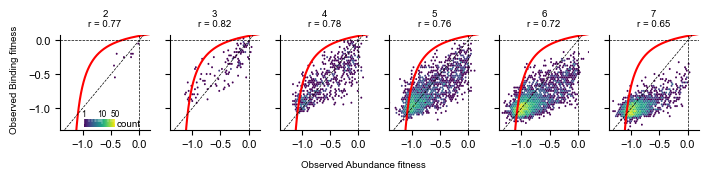

In [17]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Arial'

xlim=(min(predicted_stability_vs_binding['stability_fitness']),max(predicted_stability_vs_binding['stability_fitness']))
ylim=(min(predicted_stability_vs_binding['binding_fitness']),max(predicted_stability_vs_binding['binding_fitness']))

predicted_abundance=predicted_abundance.sort_values('stability_fitness',ascending=True)
x=predicted_abundance['stability_fitness'].iloc[35:]
y=predicted_abundance['binding_fitness_from_abundance_fitness'].iloc[35:]
y_spl=UnivariateSpline(x,y,s=0.0001)
l=len(x.index)-1
x_range = np.linspace(x[0],x[l-1],100000)

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(7,1.7))
coliterator=0
rowiterator=0
for hamm_dist in range(2,8,1):
    
    y = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['binding_fitness']].to_numpy()
    x = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['stability_fitness']].to_numpy()
    
    model = LinearRegression()
    model.fit(x,y)
    
    y_pred = model.predict(x)
    
    
    ax[coliterator].set(xlim=xlim,ylim=ylim)
    hbin=ax[coliterator].hexbin(x,y,gridsize=50,bins='log', vmax=50, rasterized=True,linewidths=0, extent=[min(predicted_stability_vs_binding['stability_fitness']),max(predicted_stability_vs_binding['stability_fitness']),min(predicted_stability_vs_binding['binding_fitness']),max(predicted_stability_vs_binding['binding_fitness'])])
    ax[coliterator].plot(x_range,y_spl(x_range),'-', color='red')

    ax[coliterator].set_title(str(hamm_dist)+'\nr = '+str(round(pearsonr(x.ravel(),y.ravel())[0],2)), fontsize=7)
    ax[coliterator].axline((0, 0), slope=1,ls='dashed',color='k',lw=0.5)
    ax[coliterator].set_ylim(min(predicted_stability_vs_binding['binding_fitness']),max(predicted_stability_vs_binding['binding_fitness']))
    ax[coliterator].set_xlim(min(predicted_stability_vs_binding['stability_fitness']),max(predicted_stability_vs_binding['stability_fitness']))
    ax[coliterator].spines[['right','top']].set_visible(False)
    ax[coliterator].set_xticks([0,-0.5,-1])
    #ax[coliterator].set_xticklabels([0,-0.5,-1])
    ax[coliterator].tick_params(axis='x', labelsize=8)
    ax[coliterator].tick_params(axis='y', labelsize=8)
    ax[coliterator].axhline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].axvline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].set_rasterization_zorder(0)
    if coliterator != 0:
        ax[coliterator].yaxis.set_ticklabels([])
    coliterator+=1
    

fmt = '%1.f'
cax=fig.add_axes([0.1,0.22,0.045,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
cb.set_ticks([1,10,50])
cb.set_ticklabels([1,10,50], fontsize=6, rotation=0)
ax1 = cb.ax
ax1.text(60,0.1,'count',rotation=0, fontsize=7)

fig.text(0.5, -0.015, 'Observed Abundance fitness', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'Observed Binding fitness', va='center', rotation='vertical', fontsize=7)
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_binding_vs_stability_observed_fitness_with_bindingfitnesspredictedfromabundancefitness_1storder3statemodel.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel i

In [18]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig7'+'/FYN_coreDTS_bPCA_order1/task_1/predictions/predicted_phenotypes_all.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

predicted_abundance = predicted_phenotypes.loc[predicted_phenotypes['Abundance']==1]
predicted_binding = predicted_phenotypes.loc[predicted_phenotypes['Binding']==1]

In [19]:
# Normalize data

from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

RT=303*0.001987

predicted_abundance_scaled = predicted_abundance.copy()
predicted_binding_scaled = predicted_binding.copy()

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

# Normalize abundance fitness measurements

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_abundance, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])


predicted_abundance_scaled['fitness']=        normalize(list(predicted_abundance_scaled['fitness']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_abundance_scaled['fitness1_uncorr']=normalize(list(predicted_abundance_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_abundance_scaled['fitness2_uncorr']=normalize(list(predicted_abundance_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Normalize abundance fitness predictions

for index, row in predicted_abundance_scaled.loc[predicted_abundance_scaled['WT']!=True].iterrows():
    predicted_abundance_scaled.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_abundance_scaled.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_abundance_scaled, x='predicted_fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

predicted_abundance_scaled['predicted_fitness']=           normalize(list(predicted_abundance_scaled['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Obtain mean inferred folding ddGs

predicted_abundance_scaled['mean_additive_trait']=predicted_abundance_scaled[['fold_'+str(i)+'_additive_trait0' for i in range(1,11,1)]].mean(axis=1)
predicted_abundance_scaled['std_additive_trait']=predicted_abundance_scaled[['fold_'+str(i)+'_additive_trait0' for i in range(1,11,1)]].std(axis=1)

predicted_abundance_scaled['mean_ddG']= predicted_abundance_scaled['mean_additive_trait']*RT
predicted_abundance_scaled['std_ddG']=  predicted_abundance_scaled['std_additive_trait']*RT

# Normalize binding fitness measurements

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_binding, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])


predicted_binding_scaled['fitness']=        normalize(list(predicted_binding_scaled['fitness']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness1_uncorr']=normalize(list(predicted_binding_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness2_uncorr']=normalize(list(predicted_binding_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness3_uncorr']=normalize(list(predicted_binding_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Normalize binding fitness predictions

for index, row in predicted_binding_scaled.loc[predicted_binding_scaled['WT']!=True].iterrows():
    predicted_binding_scaled.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_binding_scaled.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_binding_scaled, x='predicted_fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

predicted_binding_scaled['predicted_fitness']=           normalize(list(predicted_binding_scaled['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Obtain mean inferred binding ddGs

predicted_binding_scaled['mean_additive_trait']=predicted_binding_scaled[['fold_'+str(i)+'_additive_trait1' for i in range(1,11,1)]].mean(axis=1)
predicted_binding_scaled['std_additive_trait']=predicted_binding_scaled[['fold_'+str(i)+'_additive_trait1' for i in range(1,11,1)]].std(axis=1)

predicted_binding_scaled['mean_ddG']= predicted_binding_scaled['mean_additive_trait']*RT
predicted_binding_scaled['std_ddG']=  predicted_binding_scaled['std_additive_trait']*RT

In [20]:
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'predicted_fitness': 'predicted_stability_fitness'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'predicted_fitness': 'predicted_binding_fitness'})
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'fitness': 'stability_fitness'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'fitness': 'binding_fitness'})
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'mean_ddG': 'folding_ddG'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'mean_ddG': 'binding_ddG'})
predicted_stability_vs_binding = predicted_binding_scaled.merge(predicted_abundance_scaled, left_on='aa_seq', right_on='aa_seq')

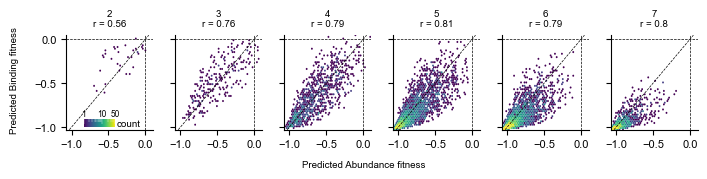

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math

plt.rcParams['font.family'] = 'Arial'

xlim=(min(predicted_stability_vs_binding['predicted_stability_fitness']),max(predicted_stability_vs_binding['predicted_stability_fitness']))
ylim=(min(predicted_stability_vs_binding['predicted_binding_fitness']),max(predicted_stability_vs_binding['predicted_binding_fitness']))

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(7,1.7))
coliterator=0
rowiterator=0
for hamm_dist in range(2,8,1):
    #predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist].plot.scatter(y='stability_fitness', x='binding_fitness')
    
    y = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['predicted_binding_fitness']].to_numpy()
    x = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['predicted_stability_fitness']].to_numpy()
    
    model = LinearRegression()
    model.fit(x,y)
    
    y_pred = model.predict(x)
    
    ax[coliterator].set(xlim=xlim,ylim=ylim)
    hbin=ax[coliterator].hexbin(x,y,gridsize=50,bins='log', vmax=50, rasterized=True,linewidths=0, extent=[min(predicted_stability_vs_binding['predicted_stability_fitness']),max(predicted_stability_vs_binding['predicted_stability_fitness']),min(predicted_stability_vs_binding['predicted_binding_fitness']),max(predicted_stability_vs_binding['predicted_binding_fitness'])])
    ax[coliterator].set_title(str(hamm_dist)+'\nr = '+str(round(pearsonr(x.ravel(),y.ravel())[0],2)), fontsize=7)
    ax[coliterator].axline((0, 0), slope=1,ls='dashed',color='k',lw=0.5)
    ax[coliterator].set_ylim(min(predicted_stability_vs_binding['predicted_binding_fitness']),max(predicted_stability_vs_binding['predicted_binding_fitness']))
    ax[coliterator].set_xlim(min(predicted_stability_vs_binding['predicted_stability_fitness']),max(predicted_stability_vs_binding['predicted_stability_fitness']))
    ax[coliterator].spines[['right','top']].set_visible(False)
    ax[coliterator].set_xticks([0,-0.5,-1])
    #ax[coliterator].set_xticklabels([0,-0.5,-1])
    ax[coliterator].tick_params(axis='x', labelsize=8)
    ax[coliterator].tick_params(axis='y', labelsize=8)
    ax[coliterator].axhline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].axvline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].set_rasterization_zorder(0)
    if coliterator != 0:
        ax[coliterator].yaxis.set_ticklabels([])
    coliterator+=1
    
#fmt = '%1.f'
#cax=fig.add_axes([0.99,0.25,0.005,0.3])
#cb=fig.colorbar(hbin, shrink=0.7,format=fmt,cax=cax)
#cb.ax.set_title('Counts',fontsize=7)
##cb.set_label('counts', rotation=270, fontsize=7, labelpad=8)
#cb.set_ticks([1,5,10,50])
#cb.set_ticklabels([1,5,10,50], fontsize=6)

fmt = '%1.f'
cax=fig.add_axes([0.1,0.22,0.045,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
#cb.ax.set_title('Count', fontsize=7)
#cb.set_label('count', rotation=0, fontsize=7, labelpad=2)
#cb.ax.xaxis.set_label_position('right')
cb.set_ticks([1,10,50])
cb.set_ticklabels([1,10,50], fontsize=6, rotation=0)
ax1 = cb.ax
ax1.text(60,0.1,'count',rotation=0, fontsize=7)

fig.text(0.5, -0.015, 'Predicted Abundance fitness', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'Predicted Binding fitness', va='center', rotation='vertical', fontsize=7)
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_binding_vs_stability_predicted_fitness_1stordermodel.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel j

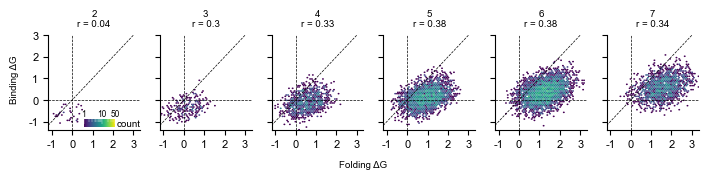

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math

plt.rcParams['font.family'] = 'Arial'

xlim=(min(predicted_stability_vs_binding['folding_ddG']),max(predicted_stability_vs_binding['folding_ddG']))
ylim=(min(predicted_stability_vs_binding['binding_ddG']),max(predicted_stability_vs_binding['binding_ddG']))

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(7,1.7))
coliterator=0
rowiterator=0
for hamm_dist in range(2,8,1):
    y = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['binding_ddG']].to_numpy()
    x = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['folding_ddG']].to_numpy()
    
    model = LinearRegression()
    model.fit(x,y)
    
    y_pred = model.predict(x)
    
    ax[coliterator].set(xlim=xlim,ylim=ylim)
    hbin=ax[coliterator].hexbin(x,y,gridsize=50,bins='log', vmax=50, rasterized=True,linewidths=0, extent=[min(predicted_stability_vs_binding['folding_ddG']),max(predicted_stability_vs_binding['folding_ddG']),min(predicted_stability_vs_binding['binding_ddG']),max(predicted_stability_vs_binding['binding_ddG'])])
    ax[coliterator].set_title(str(hamm_dist)+'\nr = '+str(round(pearsonr(x.ravel(),y.ravel())[0],2)), fontsize=7)
    ax[coliterator].axline((0, 0), slope=1,ls='dashed',color='k',lw=0.5)
    ax[coliterator].set_ylim(min(predicted_stability_vs_binding['binding_ddG']),max(predicted_stability_vs_binding['binding_ddG']))
    ax[coliterator].set_xlim(min(predicted_stability_vs_binding['folding_ddG']),max(predicted_stability_vs_binding['folding_ddG']))
    ax[coliterator].spines[['right','top']].set_visible(False)
    ax[coliterator].set_xticks(ticks=np.arange(-1,4,1), labels=np.arange(-1,4,1))
    ax[coliterator].set_yticks(ticks=np.arange(-1,4,1), labels=np.arange(-1,4,1))
    #ax[coliterator].set_xticklabels([0,-0.5,-1])
    ax[coliterator].tick_params(axis='x', labelsize=8)
    ax[coliterator].tick_params(axis='y', labelsize=8)
    ax[coliterator].axhline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].axvline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].set_rasterization_zorder(0)
    if coliterator != 0:
        ax[coliterator].yaxis.set_ticklabels([])
    coliterator+=1
    
#fmt = '%1.f'
#cax=fig.add_axes([0.99,0.25,0.005,0.3])
#cb=fig.colorbar(hbin, shrink=0.7,format=fmt,cax=cax)
#cb.ax.set_title('Counts',fontsize=7)
##cb.set_label('counts', rotation=270, fontsize=7, labelpad=8)
#cb.set_ticks([1,5,10,50])
#cb.set_ticklabels([1,5,10,50], fontsize=6)

fmt = '%1.f'
cax=fig.add_axes([0.1,0.22,0.045,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
#cb.ax.set_title('Count', fontsize=7)
#cb.set_label('count', rotation=0, fontsize=7, labelpad=2)
#cb.ax.xaxis.set_label_position('right')
cb.set_ticks([1,10,50])
cb.set_ticklabels([1,10,50], fontsize=6, rotation=0)
ax1 = cb.ax
ax1.text(60,0.1,'count',rotation=0, fontsize=7)

fig.text(0.5, -0.015, 'Folding ΔG', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'Binding ΔG', va='center', rotation='vertical', fontsize=7)
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_binding_vs_stability_ddG_1storder3statemodel_byNham_correl.svg', dpi=300, transparent=True, bbox_inches='tight')